In [1]:
import numpy as np
import pickle
import sys
import keras.preprocessing.image 
import matplotlib.pyplot as plt
import torch
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import csv
import pandas as pd   
import os
import h5py
from sklearn.model_selection import train_test_split

In [2]:
sys.argv[1] = "mhelabd"

In [27]:
#Global Variables
WANTED_BANDS = [3, 2, 1]
IMAGE_HEIGHT, IMAGE_WIDTH, NUM_BANDS, NUM_OG_BANDS = (64, 64, len(WANTED_BANDS), 13) 
MODEL_NAME = "Augmented-drop-neighbors-offset-wide-CNN-({})-input-({}, {}, {})-bands-({})".format("Resnet50", IMAGE_HEIGHT, IMAGE_WIDTH, NUM_BANDS, str(WANTED_BANDS))
PATH = "/atlas/u/{}/data/kiln-scaling/models/{}/".format(sys.argv[1], MODEL_NAME) 
# DATA_PATH = "/atlas/u/mliu356/data/kiln-scaling/tiles_drop_neighbors/"
DATA_PATH = "/atlas/u/mliu356/data/kiln-scaling/final_tiles_indices/"
MODEL_WEIGHTS_PATH = PATH + "weights/"
MODEL_HISTORY_PATH = PATH + "history/"
MODEL_EVALUATION_PATH = PATH + "evaluation/"
MODEL_EVALUATION_IMAGE_PATH = MODEL_EVALUATION_PATH + "images/"
VERBOSE = True
BALANCE_DATASET = True
USE_BALANCED_DATASET = True
PREPROCESS = False
# BALANCED_DATA_PATH = "/atlas/u/{}/data/kiln-scaling/balanced_tiles/".format(sys.argv[1])
BALANCED_DATA_PATH = "/atlas/u/mhelabd/data/kiln-scaling/balanced_tiles/"
RANDOM_STATE = 42
NUM_RANDOM_IMAGES = 5

In [28]:
def mkdirs(names):
    for name in names:
        if not os.path.exists(name):
            os.makedirs(name)
mkdirs([MODEL_WEIGHTS_PATH, MODEL_HISTORY_PATH, MODEL_EVALUATION_PATH, MODEL_EVALUATION_IMAGE_PATH])

In [29]:
def save_h5_file(X, y, bounds):
    filename = BALANCED_DATA_PATH + ("preprocessed_" if PREPROCESS else "") + "final_tiles_drop_neighbors_offset.hdf5"
    print("Saving file", filename)
    f = h5py.File(filename, 'w')
    bounds_dset = f.create_dataset("bounds", data=bounds)
    examples_dset = f.create_dataset("images", data=X)
    labels_dset = f.create_dataset("labels", data=y)
    f.close()

def balance_and_save_h5_data(preprocess=False, verbose=VERBOSE):
    X, y = [], []
    print("processing files...")
    for i, filename in enumerate(os.listdir(DATA_PATH)):
        print(".", end="")
        with h5py.File(DATA_PATH + filename, "r") as f:
            if i == 0:
                X = np.array(f["images"][()])\
                    .reshape((-1, NUM_OG_BANDS, IMAGE_HEIGHT, IMAGE_WIDTH))
                y = np.array(f["labels"][()])
                bounds = np.array(f["bounds"][()])
            else:
                x_i = np.array(f["images"][()])\
                    .reshape((-1, NUM_OG_BANDS, IMAGE_HEIGHT, IMAGE_WIDTH))
                X = np.concatenate((X, x_i))

                y_i = np.array(f["labels"][()])
                y = np.concatenate((y, y_i))

                bounds_i = np.array(f["bounds"][()])
                bounds = np.concatenate((bounds, bounds_i))
            try:
                mask = np.isnan(X).any(axis=1).any(axis=1).any(axis=1)
                mask = ~mask
                X, y, bounds = X[mask], y[mask], bounds[mask]
                n = y[y==1].shape[0]
                mask = np.hstack([np.random.choice(np.where(y == l)[0], n, replace=False) for l in np.unique(y)])
                X = X[mask]
                y = y[mask]
                bounds = bounds[mask]
            except ValueError:
                print("file has more positive than negative examples")
    n = min([ y[y==1].shape[0], y[y==0].shape[0] ])
    mask = np.hstack([np.random.choice(np.where(y == l)[0], n, replace=False) for l in np.unique(y)])
    X = X[mask]
    y = y[mask]
    bounds = bounds[mask]
    print("X.shape: ", X.shape)
    print("y.shape: ", y.shape)
    print("bounds.shape: ", bounds.shape)
    
    save_h5_file(X, y, bounds)

In [30]:
# balance_and_save_h5_data()

In [31]:
def load_data_from_h5(preprocess=PREPROCESS, verbose=VERBOSE, \
                      balance_dataset=BALANCE_DATASET, use_balanced_dataset=USE_BALANCED_DATASET):
    X, y = [], []
    data_path = BALANCED_DATA_PATH if use_balanced_dataset else DATA_PATH
    if use_balanced_dataset:
        filename = "final_tiles_drop_neighbors_offset.hdf5"
        with h5py.File(data_path + filename, "r") as f:
            print("extracting: ", filename) 
            X = np.array(f["images"][()])\
                .reshape((-1, NUM_OG_BANDS, IMAGE_HEIGHT, IMAGE_WIDTH))
            X = np.moveaxis(X, 1, -1)[:, :, :, WANTED_BANDS]
            y = np.array(f["labels"][()])
            bounds = np.array(f["bounds"][()])
    else:
        for i, filename in enumerate(os.listdir(data_path)):
            print("extracting: ",filename) 
            with h5py.File(data_path + filename, "r") as f:
                if i == 0:
                    X = np.array(f["images"][()])\
                        .reshape((-1, NUM_OG_BANDS, IMAGE_HEIGHT, IMAGE_WIDTH))
                    X = np.moveaxis(X, 1, -1)[:, :, :, WANTED_BANDS]
                    y = np.array(f["labels"][()])
                    bounds = np.array(f["bounds"][()])
                else:
                    x_i = np.array(f["images"][()])\
                        .reshape((-1, NUM_OG_BANDS, IMAGE_HEIGHT, IMAGE_WIDTH))
                    x_i = np.moveaxis(x_i, 1, -1)[:, :, :, WANTED_BANDS]
                    X = np.concatenate((X, x_i))
                    y_i = np.array(f["labels"][()])
                    y = np.concatenate((y, y_i))

                    bounds_i = np.array(f["bounds"][()])
                    bounds = np.concatenate((bounds, bounds_i))
            
            mask = np.isnan(X).any(axis=1).any(axis=1).any(axis=1)
            mask = ~mask
            X, y, bounds = X[mask], y[mask], bounds[mask]
            
            if balance_dataset:
                #since y = 1 is always less
                n= y[y==1].shape[0]
                mask = np.hstack([np.random.choice(np.where(y == l)[0], n, replace=False)
                                  for l in np.unique(y)])
                X = X[mask]
                y = y[mask]
                bounds = bounds[mask]
    if preprocess:
        X = preprocess_input(X)  
    if verbose:
        print("x shape: ", X.shape)
        print("y shape: ", y.shape)
    return X, y, bounds

In [32]:
def load_data_from_csv(preprocess=True, verbose=VERBOSE):
    for i in range(24):
        if i == 0:
            x_pos = np.loadtxt(DATA_PATH + 'pos_x_examples'+ str(i)+'.csv', delimiter=',')\
                .reshape((-1, IMAGE_HEIGHT, IMAGE_WIDTH, NUM_BANDS))
            x_neg = np.loadtxt(DATA_PATH + 'neg_x_examples'+ str(i)+'.csv', delimiter=',')\
                .reshape((-1, IMAGE_HEIGHT, IMAGE_WIDTH, NUM_BANDS))
        else:
            x_pos_i = np.loadtxt(DATA_PATH + 'pos_x_examples'+ str(i)+'.csv', delimiter=',')\
                .reshape((-1, IMAGE_HEIGHT, IMAGE_WIDTH, NUM_BANDS))
            x_pos = np.concatenate((x_pos, x_pos_i))
            x_neg_i = np.loadtxt(DATA_PATH + 'neg_x_examples'+ str(i)+'.csv', delimiter=',')\
                .reshape((-1, IMAGE_HEIGHT, IMAGE_WIDTH, NUM_BANDS))
            x_neg = np.concatenate((x_neg, x_neg_i))
    if verbose:
        print("x_pos.shape: ", x_pos.shape)
        print("x_neg.shape: ", x_neg.shape)
    if preprocess:
        x_pos = preprocess_input(x_pos)
        x_neg = preprocess_input(x_neg)

    X = np.concatenate((x_pos, x_neg))    
    # y is a vector of ones (kilns present) and zeros (kilns absent)
    y = np.concatenate((np.ones(len(x_pos)), np.zeros(len(x_neg) ) )).reshape(-1, 1)
    if verbose:
        print("x shape: ", X.shape)
        print("y shape: ", y.shape)
    return X, y
    

In [ ]:
def split_data(X, y, train_percent=0.7, val_percent=0.1, test_percent=0.2):
    assert train_percent + val_percent + test_percent == 1
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_percent, random_state=RANDOM_STATE)
    updated_val_precent = val_percent/(1 - test_percent)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=updated_val_precent, random_state=RANDOM_STATE)
    
    return (torch.tensor(X_train).float(), 
            torch.tensor(X_val).float(),
            torch.tensor(X_test).float(),
            torch.tensor(y_train),
            torch.tensor(y_val),
            torch.tensor(y_test))

In [34]:
def crop(start, end):
    # Crops (or slices) a Tensor from start to end
    def func(x):
        return x[:, :, :, start: end]
    return Lambda(func)

In [45]:
def make_wide_resnet_model():
#     preprocess = transforms.Compose([
#     transforms.Resize(256),
#     transforms.CenterCrop(224),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#     ])
#     input_tensor = preprocess(input_image)
#     input_batch = input_tensor.unsqueeze(0)
    
    model = models.wide_resnet50_2(pretrained=True)
    return model

In [36]:
def graph_model_performance(history):
    # IF METRICS ARE UPDATED, YOU MUST UPDATE THIS
    # summarize history for accuracy
    plt.plot(list(history['binary_accuracy']))
    plt.plot(list(history['val_binary_accuracy']))
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    plt.savefig(MODEL_EVALUATION_PATH + "accuracy.png")
    plt.clf()
    # summarize history for loss
    plt.plot(list(history['loss']))
    plt.plot(list(history['val_loss']))
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    plt.savefig(MODEL_EVALUATION_PATH + "loss.png")
    plt.clf()

In [37]:
def print_images(x, name):
    normalized_x = x/np.max(x)
    plt.imshow(normalized_x)
    plt.show()
    plt.savefig(MODEL_EVALUATION_IMAGE_PATH + name)
    plt.clf()
def evaluate_dataset(model, X, y, threshold=0.5, pictures=True, dataset_type="test"):
    # Evaluate the model on the test data using `evaluate`
    results = model.evaluate(X, y, batch_size=128)
    print(dict(zip(model.metrics_names, results)))

    y_pred = model.predict(X) > threshold
    print(tf.math.confusion_matrix(y.reshape(-1), y_pred.reshape(-1)))
    
    if pictures:
        print("Generating {} false positives and {} false negatives...".format(NUM_RANDOM_IMAGES, NUM_RANDOM_IMAGES))

        false_positives = np.logical_and(y != y_pred, y_pred == 1)
        X_fp = X[false_positives.reshape(-1), :, :]
        #gets you the location of every false positive in X
        false_positives_index = np.argwhere(false_positives)

        false_negatives = np.logical_and(y != y_pred, y_pred == 0)
        X_fn = X[false_negatives.reshape(-1), :, :]
        false_negatives_index = np.argwhere(false_negatives)

        
    for i in range(NUM_RANDOM_IMAGES):
        if len(X_fp) > 0:
            randi = np.random.randint(0, len(X_fp))
            X_fp_i = false_positives_index[randi][0]
            confidence = model.predict(np.expand_dims(X[X_fp_i], axis=0))[0][0]
            print_images(X_fp[randi], "{}_fp_example{}_confidence_{}_coordinates({}).png"\
                         .format(dataset_type, X_fp_i, confidence, str(bounds[X_fp_i])))
        if len(X_fn) > 0:
            randi = np.random.randint(0, len(X_fn))
            X_fn_i = false_negatives_index[randi][0]
            confidence = model.predict(np.expand_dims(X[X_fn_i], axis=0))[0][0]
            print_images(X_fn[randi],  "{}_fn_example{}_confidence_{}_coordinates({}).png"\
                         .format(dataset_type, X_fn_i, confidence, str(bounds[X_fn_i])))

def evaluate_model(model, X_train, X_val, X_test, y_train, y_val, y_test, threshold=0.5, pictures=True):
    print("Evaluating Training data: ")
    evaluate_dataset(model, X_train, y_train, threshold=threshold, pictures=pictures, dataset_type="train")

    print("Evaluating Validation data: ")
    evaluate_dataset(model, X_val, y_val, threshold=threshold, pictures=pictures, dataset_type="val")

    print("Evaluating Test data: ")
    evaluate_dataset(model, X_test, y_test, threshold=threshold, pictures=pictures, dataset_type="test")


In [38]:
def visualize_tile(image, indices=[3, 2, 1]):
    row_idx = np.array(indices)
    X = image
    X *= 1 / np.max(X)
    print(X.shape)
    plt.imshow(X)
def Augment_data():
    datagen = keras.preprocessing.image.ImageDataGenerator(
        horizontal_flip=True,
        vertical_flip=True
    )
    return datagen

In [39]:
def remove_nans(X, y, bounds):
    mask = np.isnan(X).any(axis=1).any(axis=1).any(axis=1)
    mask = ~mask
    X, y, bounds = X[mask], y[mask], bounds[mask]
    #since y = 1 is always less
    n= min(y[y==1].shape[0], y[y==0].shape[0])
    mask = np.hstack([np.random.choice(np.where(y == l)[0], n, replace=False)
                          for l in np.unique(y)])
    X, y, bounds = X[mask], y[mask], bounds[mask]
    print("X shape: ", X.shape)
    print("y shape: ", y.shape)
    return X, y, bounds

In [40]:
X, y, bounds = load_data_from_h5()

extracting:  final_tiles_drop_neighbors_offset.hdf5
x shape:  (12516, 64, 64, 3)
y shape:  (12516, 1)


In [41]:
X, y, bounds = remove_nans(X, y, bounds)

X shape:  (12516, 64, 64, 3)
y shape:  (12516, 1)


In [42]:
X = np.moveaxis(X, -1, 1)

In [49]:
X_train, X_val, X_test, y_train, y_val, y_test = split_data(X, y, train_percent=0.7, val_percent=0.1, test_percent=0.2)

In [46]:
model = make_wide_resnet_model()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [ ]:
num_epochs = 100
for epoch in range(num_epochs):
    for i, (inputs,labels) in enumerate (train_loader):
        inputs = Variable(inputs.float())
        labels = Variable(labels.float())
        output = net(inputs)
        optimizer.zero_grad()
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

    #Accuracy
    output = (output>0.5).float()
    correct = (output == labels).float().sum()
    print("Epoch {}/{}, Loss: {:.3f}, Accuracy: {:.3f}".format(epoch+1,num_epochs, loss.data[0], correct/x.shape[0]))

In [ ]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    optimizer.zero_grad()

    outputs = model(X_train.float())
    loss = criterion(X_train, y_train)
    loss.backward()
    optimizer.step()

    # print statistics
    running_loss += loss.item()
    if i % 2000 == 1999:    # print every 2000 mini-batches
        print('[%d, %5d] loss: %.3f' %
              (epoch + 1, i + 1, running_loss / 2000))
        running_loss = 0.0

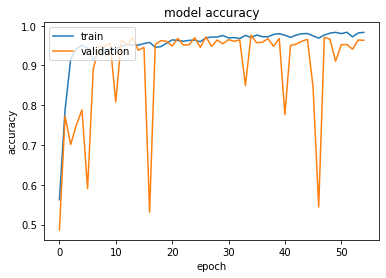

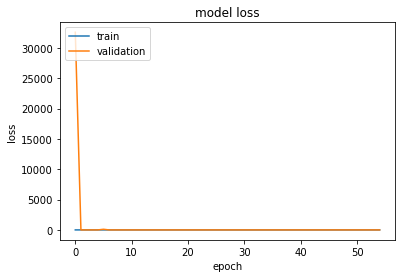

<Figure size 432x288 with 0 Axes>

In [123]:
graph_model_performance(history.history)

Evaluating Training data: 
69/69 [==============================] - 2s 25ms/step - loss: 0.0789 - binary_accuracy: 0.9797
{'loss': 0.07892276346683502, 'binary_accuracy': 0.9796803593635559}
tf.Tensor(
[[4273  109]
 [  69 4309]], shape=(2, 2), dtype=int32)
Generating 5 false positives and 5 false negatives...


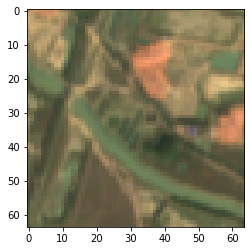

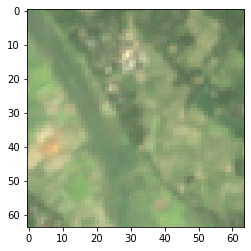

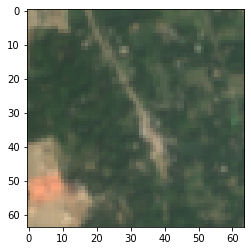

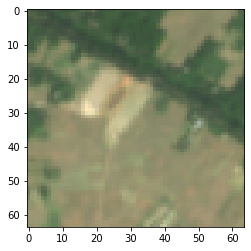

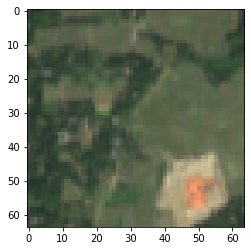

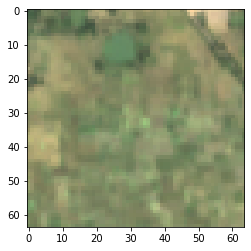

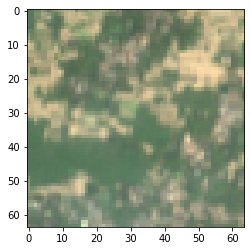

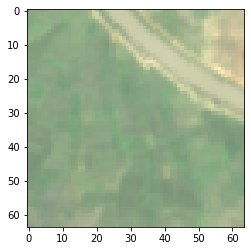

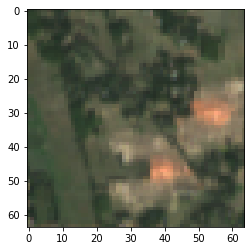

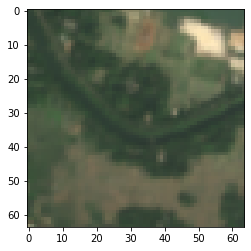

Evaluating Validation data: 
10/10 [==============================] - 0s 40ms/step - loss: 0.1787 - binary_accuracy: 0.9633
{'loss': 0.1787373423576355, 'binary_accuracy': 0.9632588028907776}
tf.Tensor(
[[585  24]
 [ 22 621]], shape=(2, 2), dtype=int32)
Generating 5 false positives and 5 false negatives...


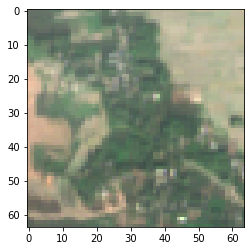

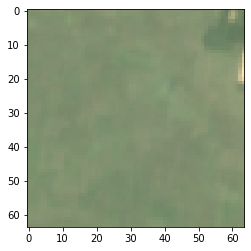

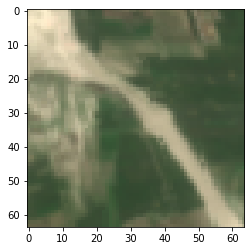

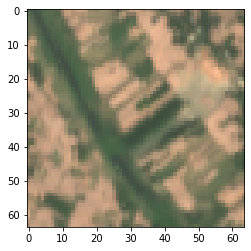

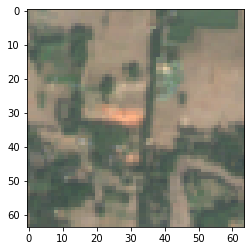

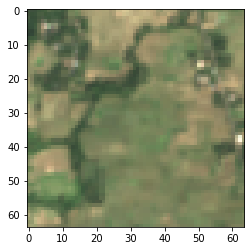

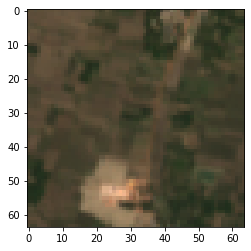

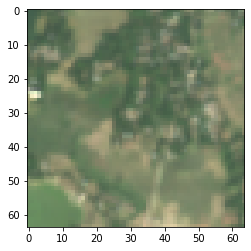

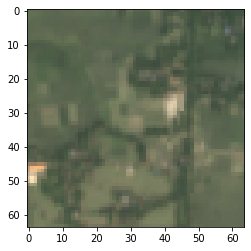

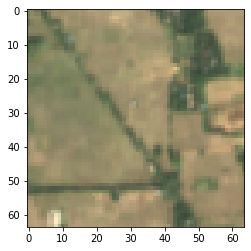

Evaluating Test data: 
20/20 [==============================] - 1s 31ms/step - loss: 0.2218 - binary_accuracy: 0.9597
{'loss': 0.2218211591243744, 'binary_accuracy': 0.959664523601532}
tf.Tensor(
[[1223   44]
 [  57 1180]], shape=(2, 2), dtype=int32)
Generating 5 false positives and 5 false negatives...


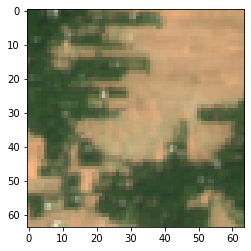

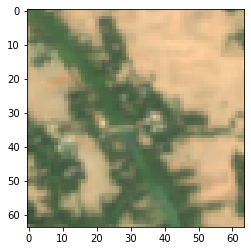

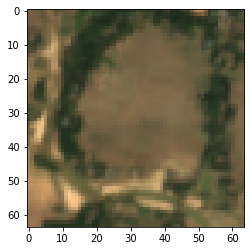

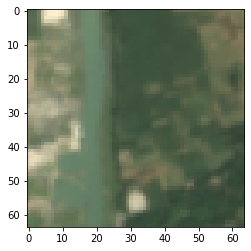

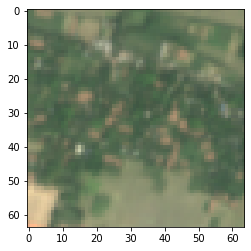

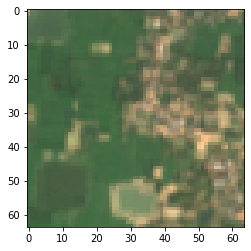

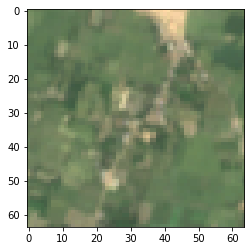

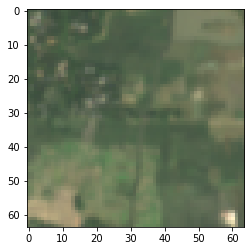

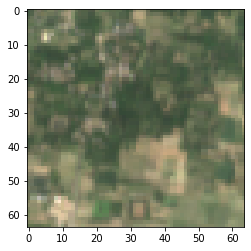

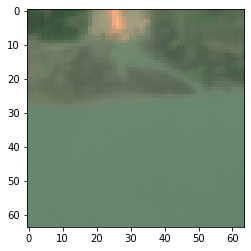

<Figure size 432x288 with 0 Axes>

In [124]:
evaluate_model(model, X_train, X_val, X_test, y_train, y_val, y_test)

In [24]:
MODEL_EVALUATION_IMAGE_PATH

'/atlas/u/-f/data/kiln-scaling/models/CNN-(Resnet50)-input-(64, 64, 3)-bands-([3, 2, 1])/evaluation/images/'